In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy import spatial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [65]:
liked_songs = pd.read_parquet('datasets/cleaned/music-recommendation-system/liked-songs.parquet')
unheard_songs = pd.read_parquet('datasets/cleaned/music-recommendation-system/unheard-songs.parquet')
df = pd.concat([liked_songs, unheard_songs[unheard_songs['like'].notnull()]], ignore_index=True)
df['listen'] = df['listen'].astype(int)
df['like'] = df['like'].astype(int)
df.tail()

,id,title,artist(s),popularity,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,listen,like
152,1lF7uD9Yu2CL17a6tm4Tkh,no longer bound,"Forrest Frank, Hulvey",72,0.552,0.698,5,-7.223,1,0.1880,...,0.505,77.558,audio_features,spotify:track:1lF7uD9Yu2CL17a6tm4Tkh,https://api.spotify.com/v1/tracks/1lF7uD9Yu2CL...,https://api.spotify.com/v1/audio-analysis/1lF7...,173195,4,1,0
153,67u4rpzdgdiPjRGZii9GEz,they call this love,XO Xuded,45,0.770,0.345,1,-10.543,1,0.0832,...,0.152,117.071,audio_features,spotify:track:67u4rpzdgdiPjRGZii9GEz,https://api.spotify.com/v1/tracks/67u4rpzdgdiP...,https://api.spotify.com/v1/audio-analysis/67u4...,173117,4,1,0
154,73tnLQtl7FqD0MS7VEM0xi,You,Elle Eliades,42,0.702,0.247,1,-8.769,0,0.0303,...,0.287,113.015,audio_features,spotify:track:73tnLQtl7FqD0MS7VEM0xi,https://api.spotify.com/v1/tracks/73tnLQtl7FqD...,https://api.spotify.com/v1/audio-analysis/73tn...,231504,3,1,0
155,3nzK0WPzGPczWa45eIFphc,Missing Sumthin',Nbdy,51,0.721,0.365,2,-10.680,0,0.1420,...,0.803,76.059,audio_features,spotify:track:3nzK0WPzGPczWa45eIFphc,https://api.spotify.com/v1/tracks/3nzK0WPzGPcz...,https://api.spotify.com/v1/audio-analysis/3nzK...,135789,4,1,1
156,1OBK4DltPHWoeilauCyckU,Sky is the Limit,Mark Ambor,63,0.519,0.256,4,-14.184,1,0.0444,...,0.281,122.715,audio_features,spotify:track:1OBK4DltPHWoeilauCyckU,https://api.spotify.com/v1/tracks/1OBK4DltPHWo...,https://api.spotify.com/v1/audio-analysis/1OBK...,159345,4,1,0


In [68]:
float_columns = [
  'popularity', 
  'danceability', 
  'energy',
  'key', 
  'loudness', 
  'mode', 
  'speechiness', 
  'acousticness',
  'instrumentalness', 
  'liveness', 
  'valence',
  'tempo',
  'duration_ms', 
  'time_signature'
]

In [69]:
scaler = StandardScaler()

unstandardized_df = df[float_columns].copy()
standardized = scaler.fit_transform(unstandardized_df)

In [70]:
# put the standardized data back into a dataframe, as well as the `id` column back
standardized_df = pd.DataFrame(standardized, columns=float_columns)
standardized_df['id'] = df['id']
standardized_df['listen'] = df['listen']
standardized_df = standardized_df[['id'] + float_columns + ['listen']]
standardized_df.head()

,id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,listen
0,20yLo8tCAM1LXixAdBf3f2,0.784440,0.621818,1.019581,0.676403,1.255085,-1.361817,-0.773821,0.353647,-0.533397,-1.040274,2.103322,0.746506,0.453896,0.297936,1
1,1zsPaEkglFvxjAhrM8yhpr,1.919280,1.427318,0.171121,-1.219941,0.435208,-1.361817,2.477351,-1.244913,-0.532634,-0.632612,-0.197450,-0.615221,0.037896,0.297936,1
2,4ZlHgEGwZb3PCq0OWFbhcO,-0.188279,1.330201,0.587422,-1.490848,1.175357,0.734313,-0.257962,-0.781737,-0.472898,1.240578,0.673588,-0.789253,-0.088865,0.297936,1
3,6G12ZafqofSq7YtrMqUm76,1.649080,1.267360,0.591386,-1.490848,0.969428,-1.361817,-0.581317,0.014546,-0.533393,0.410329,1.667803,0.572300,-0.555997,0.297936,1
4,4X3CV9rXo3hQrkb0fzRAux,0.190000,0.084818,0.944250,0.676403,0.901851,0.734313,-0.728526,-0.793847,-0.533386,-0.818252,0.145686,-0.825129,0.845148,0.297936,1


In [96]:
spatial.distance.cosine(standardized_df.iloc[0][float_columns], standardized_df.iloc[2][float_columns])

0.6996439015495343

In [71]:
X_train, X_test, y_train, y_test = train_test_split(standardized_df[float_columns], df['like'], test_size=0.3, random_state=42)

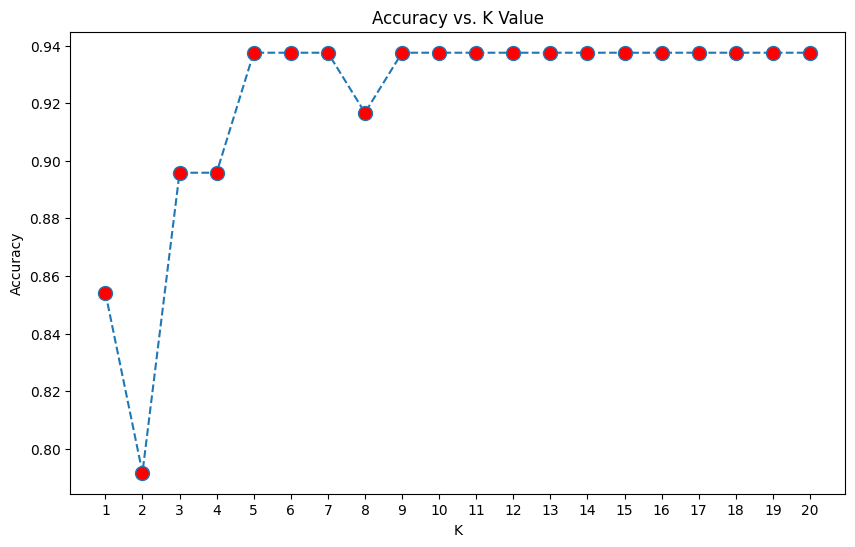

In [72]:
neighbors = np.arange(1, 21, 1)
accuracy = list()

for n in neighbors:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  accuracy.append(knn.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(neighbors, accuracy, linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.xticks(neighbors)
plt.ylabel('Accuracy')
plt.show()

In [74]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Accuracy: {}'.format(knn.score(X_test, y_test)))

Accuracy: 0.9375


In [75]:
unheard_notliked_songs = unheard_songs[unheard_songs['like'].isnull()]
unheard_notliked_songs.head()

,id,title,artist(s),popularity,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,listen,like
14,6YULY6STClTO2tekAZb81j,Chasing Pavements,Brooke Sierra,54,0.667,0.538,5,-6.206,1,0.0352,...,0.295,137.959,audio_features,spotify:track:6YULY6STClTO2tekAZb81j,https://api.spotify.com/v1/tracks/6YULY6STClTO...,https://api.spotify.com/v1/audio-analysis/6YUL...,226992,4,0,NaN
15,5tgLkUlAmTR9FhOzVVfIJS,Silence,Weston Estate,59,0.348,0.477,4,-9.567,1,0.1880,...,0.181,175.167,audio_features,spotify:track:5tgLkUlAmTR9FhOzVVfIJS,https://api.spotify.com/v1/tracks/5tgLkUlAmTR9...,https://api.spotify.com/v1/audio-analysis/5tgL...,133440,4,0,NaN
16,7B5EbapjMpLuK7A7PJUvxn,AVO TOAST,Clinton Kane,61,0.628,0.841,11,-3.673,1,0.0687,...,0.861,90.031,audio_features,spotify:track:7B5EbapjMpLuK7A7PJUvxn,https://api.spotify.com/v1/tracks/7B5EbapjMpLu...,https://api.spotify.com/v1/audio-analysis/7B5E...,161461,4,0,NaN
17,6UdU7dLYydmt6OaPItTso9,Parachute,Biishop The Artist,39,0.726,0.147,3,-11.899,1,0.0551,...,0.234,137.881,audio_features,spotify:track:6UdU7dLYydmt6OaPItTso9,https://api.spotify.com/v1/tracks/6UdU7dLYydmt...,https://api.spotify.com/v1/audio-analysis/6UdU...,278077,3,0,NaN
18,6tm4RYbhLGrFmYwSTFNFaB,Another Universe,"Melissa Polinar, Jeremy Passion, Glenn Lumanta",29,0.452,0.431,9,-9.064,1,0.0412,...,0.452,141.471,audio_features,spotify:track:6tm4RYbhLGrFmYwSTFNFaB,https://api.spotify.com/v1/tracks/6tm4RYbhLGrF...,https://api.spotify.com/v1/audio-analysis/6tm4...,195131,4,0,NaN


In [78]:
float_columns

['popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature']

In [88]:
unstandardized_df = unheard_notliked_songs[float_columns].copy()
unstandardized_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
14,54,0.667,0.538,5,-6.206,1,0.0352,0.3670,0.000000,0.1150,0.295,137.959,226992,4
15,59,0.348,0.477,4,-9.567,1,0.1880,0.7850,0.000000,0.1040,0.181,175.167,133440,4
16,61,0.628,0.841,11,-3.673,1,0.0687,0.0812,0.000000,0.0882,0.861,90.031,161461,4
17,39,0.726,0.147,3,-11.899,1,0.0551,0.7910,0.000021,0.0984,0.234,137.881,278077,3
18,29,0.452,0.431,9,-9.064,1,0.0412,0.8420,0.000002,0.1500,0.452,141.471,195131,4


In [89]:
unstandardized_df = unheard_notliked_songs[float_columns].copy()
standardized_values = scaler.fit_transform(unstandardized_df)
standardized_df = pd.DataFrame(standardized_values, columns=float_columns)
standardized_df['id'] = unheard_notliked_songs['id']
standardized_df['listen'] = unheard_notliked_songs['listen']
standardized_df.head()


,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,listen
0,0.543722,0.324337,0.652823,-0.730297,1.127092,0.480384,-0.682906,-0.818027,-0.312668,-0.072006,-0.643470,0.456619,0.747566,0.377964,NaN,NaN
1,1.055461,-1.958996,0.307107,-1.095445,0.132319,0.480384,1.345732,0.908810,-0.312668,-0.417322,-1.147740,1.592117,-1.457014,0.377964,NaN,NaN
2,1.260157,0.045184,2.370070,1.460593,1.876797,0.480384,-0.238146,-1.998721,-0.312668,-0.913321,1.860188,-1.006027,-0.796691,0.377964,NaN,NaN
3,-0.991494,0.746646,-1.563163,-1.460593,-0.557895,0.480384,-0.418705,0.933597,-0.308023,-0.593119,-0.913299,0.454239,1.951400,-2.645751,NaN,NaN
4,-2.014971,-1.214586,0.046403,0.730297,0.281195,0.480384,-0.603248,1.144288,-0.312299,1.026725,0.051008,0.563797,-0.003248,0.377964,NaN,NaN


In [85]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(standardized_df[float_columns])
unheard_notliked_songs.loc[:, 'like'] = y_pred

/var/folders/tb/18zmpr1n5g75rvhr7gcgx2600000gn/T/ipykernel_31964/1733826728.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unheard_notliked_songs.loc[:, 'like'] = y_pred


In [87]:
unheard_notliked_songs['like'].value_counts()

1    15
0     1
Name: like, dtype: int64

In [98]:
print(unheard_notliked_songs[unheard_notliked_songs['like'] == 1]['title'])

14                     Chasing Pavements
15                               Silence
16                             AVO TOAST
17                             Parachute
18                      Another Universe
19    All That Matters - Spotify Singles
20         I Didn't Know If I'd Love You
21        Unfinished Business (Acoustic)
22                                Cherie
23                                    rn
24                   Under The Influence
25                               I.Y.W.L
26                        Chasing Dreams
27     never fall in love with strangers
28                    พิจารณา (Consider)
Name: title, dtype: object


In [91]:
print(unheard_notliked_songs[unheard_notliked_songs['like'] == 0])

                        id     title       artist(s)  popularity  \
29  3vN4noEugIxWThJUeEJqQJ  Pictures  JSO, Valentine          51   

    danceability  energy  key  loudness  mode  speechiness  ...  valence  \
29         0.746   0.252    2   -15.178     1        0.214  ...    0.322   

     tempo            type                                   uri  \
29  119.74  audio_features  spotify:track:3vN4noEugIxWThJUeEJqQJ   

                                           track_href  \
29  https://api.spotify.com/v1/tracks/3vN4noEugIxW...   

                                         analysis_url duration_ms  \
29  https://api.spotify.com/v1/audio-analysis/3vN4...      184214   

   time_signature listen  like  
29              4      0     0  

[1 rows x 23 columns]
